In [215]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as wg
import IPython.display
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import get_window
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")
class STF_reflected:

    # init method or constructor 
    def __init__(self, data, window, cutoff, period = None, pad = None):
        self.data = data
        self.window = window
        self.cutoff = cutoff
        if period is None:
            freq = None
            if isinstance(data, (pd.Series, pd.DataFrame)):
                freq = getattr(data.index, 'inferred_freq', None)
            if freq is None:
                raise ValueError("Unable to determine period from data")
            period = freq_to_period(freq)
        self.period = period
        self._observed = data
        self.pad = pad

    def fit(self):
        
        dt = 1 / self.period
        t = np.array(self.data.index)

        f = np.array(self.data.squeeze())
        half = np.floor(len(t)/2)
        # Reflect f onto f on both tails
        reflected = np.append(np.flip(f), f)
        reflected = np.append(reflected, np.flip(f))
        
        self.observed = pd.Series(self.data.squeeze(), self.data.index)
      

        n = len(reflected)
        #Compute FFT
        fhat = np.fft.fft(reflected, n)
        
        # Power Spectrum
        PSD = fhat * np.conj(fhat) / n

        if self.window == "tukey":
            window = signal.tukey(len(reflected), alpha = self.pad)
        else:
            window = get_window(self.window, len(reflected))
        
        PSD = PSD*window
      
    
        # X axis of freqs
        freq = (1 / (dt*n)) * np.arange(n)

        # Plotting first half
        L = np.arange(1, np.floor(n/2), dtype = 'int')
        plt.figure()
        plt.plot(freq[L], PSD[L])
        plt.show()

        # Use the PSD to filter out noise
        # Filter out freqs with low power
        peaks = int(np.quantile(PSD, self.cutoff))
        indices = PSD < peaks
        #indices = indices[int(half):(n + int(half))]
   
        # Zero out small Fourier coefs
        fhat_clean = indices * fhat
        # Inverse FFT for filtered time signal
        ffilt = np.fft.ifft(fhat_clean)

        # Filter out freqs with high power
        indices_seasonal = PSD >= peaks
        fhat_seasonal = indices_seasonal * fhat
        ffilt_seasonal = np.fft.ifft(fhat_seasonal)

        ffilt = ffilt[len(f): (len(f)*2)]
        ffilt_seasonal = ffilt_seasonal[len(f): len(f)*2]
     
        trend = pd.Series(ffilt.real, self.data.index, name='trend')
    
        # This will be res.seasonal (ffilt_seasonal)
        season = pd.Series(ffilt_seasonal.real, self.data.index, name = 'season')
    
        # Find the residuals 
        residual = self.observed - ffilt_seasonal.real - ffilt.real
        resid = pd.Series(residual, self.data.index, name = "resid")

        
        rw = pd.Series(np.ones(len(season)), self.data.index, name="robust_weight")
      
        # Initial Statistical Summary
       # print("The rmse", math.sqrt(mean_squared_error(co2["CO2"], (ffilt_seasonal + ffilt).real)))
        #print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))
        from statsmodels.tsa.seasonal import DecomposeResult
        return DecomposeResult(self._observed, season, trend, resid, rw)

In [216]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as wg
import IPython.display
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import get_window
from sklearn.metrics import mean_squared_error
import math
import warnings
from statsmodels.tsa.tsatools import freq_to_period
warnings.filterwarnings("ignore")
class STF:


    # init method or constructor 
    def __init__(self, data, window, cutoff, period = None):
        self.data = data
        self.window = window
        self.cutoff = cutoff
        if period is None:
            freq = None
            if isinstance(data, (pd.Series, pd.DataFrame)):
                freq = getattr(data.index, 'inferred_freq', None)
            if freq is None:
                raise ValueError("Unable to determine period from data")
            period = freq_to_period(freq)
        self.period = period
        self._observed = data
        self.pad = 12 / period 

    def fit(self):
        
        dt = 1 / self.period
        t = np.array(self.data.index)

        f = np.array(self.data.squeeze())
        
        self.observed = pd.Series(self.data.squeeze(), self.data.index)
      

        n = len(t)
        #Compute FFT
        fhat = np.fft.fft(f, n)
        # Power Spectrum
        PSD = fhat * np.conj(fhat) / n

        if self.window == "tukey":
            window = signal.tukey(len(f), alpha = self.pad) # We will need to be able to adjust the width of the windows, because we don't want the freq window to be dependent of the length of the TS alone
            # Add the alpha parameter to function as the seasonality parameter
        else:
            window = get_window(self.window, len(f)) 
        
        PSD = PSD*window
      
    
        # X axis of freqs
        freq = (1 / (dt*n)) * np.arange(n)

        # Plotting first half
        L = np.arange(1, np.floor(n/2), dtype = 'int')

        plt.figure()
        plt.plot(freq[L], PSD[L])
        plt.show()


        # Use the PSD to filter out noise
        # Filter out freqs with low power
        peaks = int(np.quantile(PSD, self.cutoff))
        indices = PSD < peaks
        #indices = indices[int(half):(n + int(half))]
   
        # Zero out small Fourier coefs
        fhat_clean = indices * fhat
        # Inverse FFT for filtered time signal
        ffilt = np.fft.ifft(fhat_clean)

        # Filter out freqs with high power
        indices_seasonal = PSD >= peaks
        fhat_seasonal = indices_seasonal * fhat
        ffilt_seasonal = np.fft.ifft(fhat_seasonal)
     
        trend = pd.Series(ffilt.real, self.data.index, name='trend')
    
        # This will be res.seasonal (ffilt_seasonal)
        season = pd.Series(ffilt_seasonal.real, self.data.index, name = 'season')
    
        # Find the residuals 
        residual = self.observed - ffilt_seasonal.real - ffilt.real
        resid = pd.Series(residual, self.data.index, name = "resid")

        
        rw = pd.Series(np.ones(len(season)), self.data.index, name="robust_weight")
      
        # Initial Statistical Summary
       # print("The rmse", math.sqrt(mean_squared_error(co2["CO2"], (ffilt_seasonal + ffilt).real)))
        #print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))
        from statsmodels.tsa.seasonal import DecomposeResult
        return DecomposeResult(self._observed, season, trend, resid, rw)

257


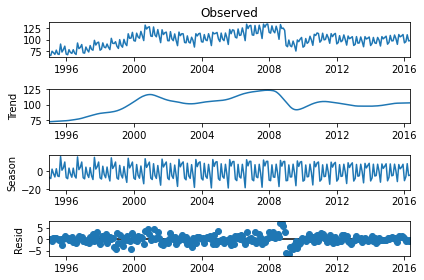

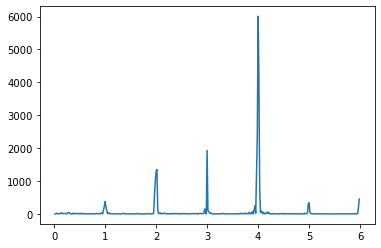

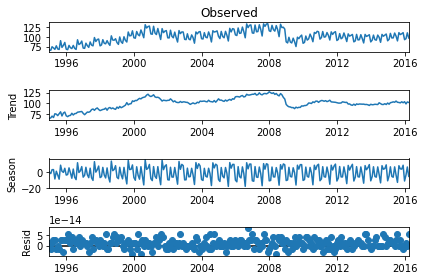

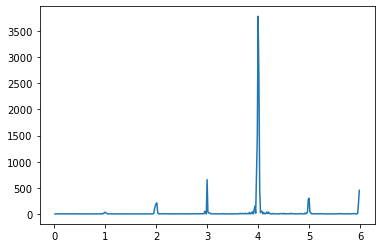

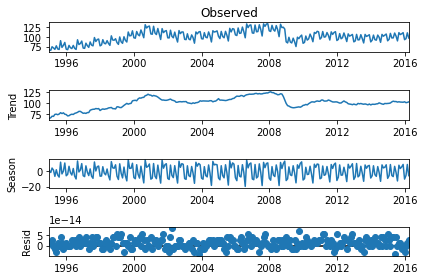

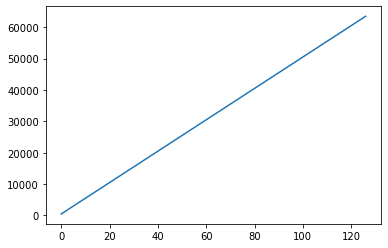

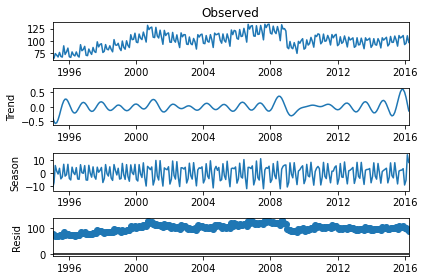

In [217]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import elec_equip as ds
import statsmodels.datasets


#TODO: 3/23/2022
# Append one row to make an even array
# Double the length and pad with zeros 

# Test stf vs stl on elec_equip data
elec_equip = ds.load().data
stl = STL(elec_equip, seasonal = 13)
res_robust = stl.fit()
fig = res_robust.plot()
print(len(elec_equip))

stf = STF_reflected(elec_equip[:256], "tukey", .915, pad = 0.45)
res = stf.fit()
fig = res.plot()

stf = STF_reflected(elec_equip[:256], "blackman", .8, pad = 1)
res = stf.fit()
fig = res.plot()

stf = STF(elec_equip[:256], "blackman", cutoff=1e4)
res = stf.fit()
fig = res.plot()

The elec_equip decomposition for STF has the least amount of tail fluctuation when the data is reflected and a blackman window is used along with a 0.8 cutoff
- Right tail fluctuation is fixed for STF with tukey window when the data the last data point is cutoff, making the length of the dataset even. A 0.92 cutoff is used with a padding of 0.45 for the window. Left tail fluctuation is still an issue. 

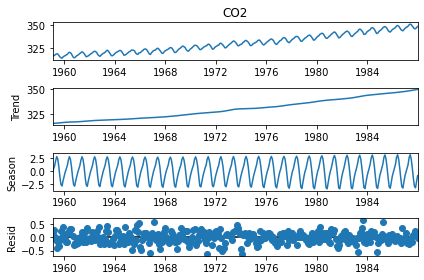

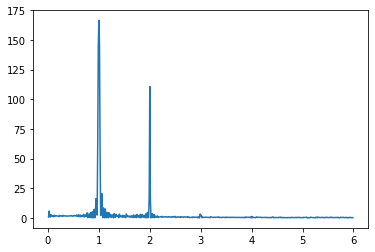

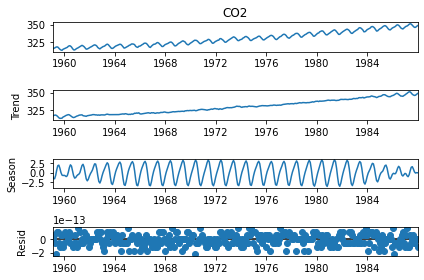

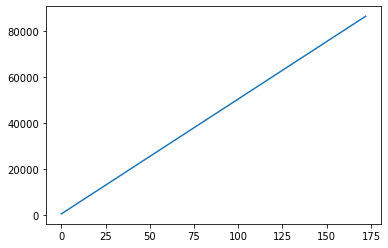

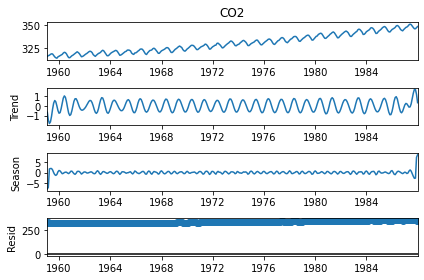

In [218]:
co2 =pd.read_csv('../data/co2.csv', index_col='date', parse_dates=True, squeeze=True)

stl = STL(co2, seasonal=13)
res = stl.fit()
fig = res.plot()


stf = STF_reflected(co2, "tukey", .98, pad = .4)
res = stf.fit()
fig = res.plot()


stf = STF(co2, "tukey", cutoff=2e4)
res = stf.fit()
fig = res.plot()

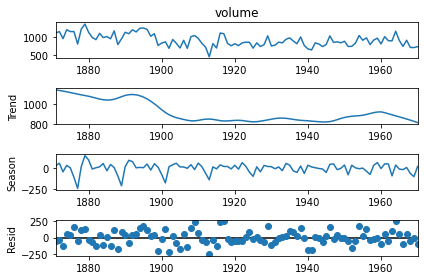

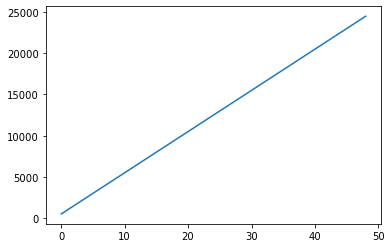

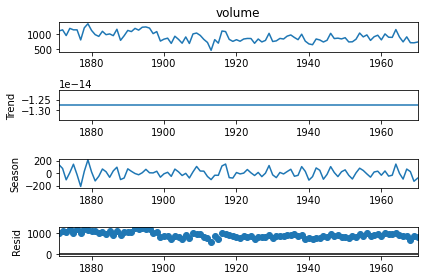

In [219]:
# Test stf vs stl on elec_equip data
data = statsmodels.datasets.nile.load().data

data.index = data["year"]
stl = STL(data["volume"], period = 12, seasonal = 13)
res = stl.fit()
fig = res.plot()

stf = STF(data["volume"], window="blackman", cutoff = 0.35, period = 12)
res = stf.fit()
fig = res.plot()



TypeError: __init__() got an unexpected keyword argument 'pad'

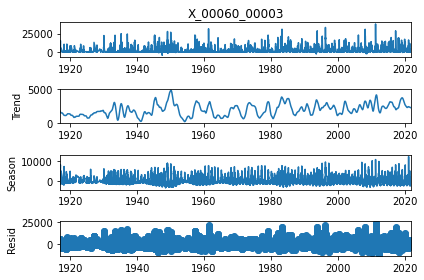

In [220]:
streamflow = pd.read_csv('../data/big_muddy_streamflow.csv', index_col='Date', parse_dates=True, squeeze=True)
stl = STL(streamflow["X_00060_00003"], period = 365)
res = stl.fit()
fig = res.plot()

streamflow = streamflow.fillna(0)
stf = STF(streamflow["X_00060_00003"], "tukey", 0.4, period = 365, pad = 1)
res = stf.fit()
res.plot()

streamflow = streamflow.fillna(0)
stf = STF_reflected(streamflow["X_00060_00003"], "tukey", 0.9, period = 365, pad = 1)
res = stf.fit()
res.plot()

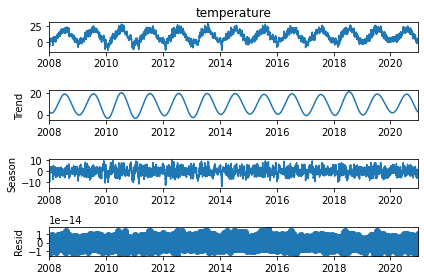

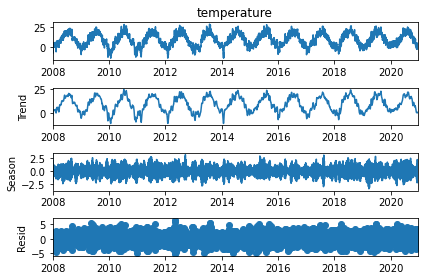

In [ ]:
from numpy.fft import rfft, irfft, rfftfreq, fft, ifft, fftfreq
data = pd.read_csv('https://gist.githubusercontent.com/fischerbach/47985e9fb0a331d2aebba303fb3d5ad1/raw/b06b938dc193b326e7e2edb836c19d12ba4295d1/weather.csv')
data['ds'] = pd.to_datetime(data['ds'])
data.set_index('ds', inplace=True)

stf = STF(data["temperature"], window="blackman", cutoff = 1e4, period = 12)
res = stf.fit()
fig = res.plot()

stf = STL(data["temperature"])
res = stf.fit()
fig = res.plot()